# Outline
In this folder you will find the following notebooks (numbered)
*    **Data Analysis**:
       
    1. EDA (this notebook)        
    2. Outlier Analisys        
    3. Feature Engineering

*    **Non sequence Models**:
    4. Baseline Model (historical average) and Linear Regression
    5. XGBoost & lighGBM (and stacked models)
*    **Sequence Models**
    6. LSTMs
    7. CNN-LSTMs
    8. BiLSMTs
*    **Sequence + Attention**
    9. Transformed Based
    10. Transformed Based II (with engineered features)
*   **Extra**:
    * test01: ARIMA
    * test02: fb prophet

# Summary 
## Dataset
* 1 file, no need to merge datasets
* 43,847 rows and 8 columns.
* No NaNs
* **Timestamps** (contract-delivery, day-ahead-auction-time) are in object format (strings). We should convert them to datetime.
  * Did not use ~~day-ahead-auction-time~~.
  * Hourly data
  * Initial Date: 2020-02-05 01:00:00+00:00
  * Final Date: 2024-12-31 22:00:00+00:00
  * ✅  Total Missing Timestamps: 0
* **Features**:
  * demand-forecast, temperature-normal, temperature-forecast, solar-forecast, wind-forecast are **numeric variables**.
  * 🔴 **solar-forecast** has many zeros, likely due to nighttime hours?
  * 🔴 **solar-forecast**, **wind-forecast**, **day-ahead-auction-price** are left-skewed, could be transformed to Gaussian
* **Target variable (day-ahead-auction-price)**
    * 🔴 has extreme **outliers**
    * **periodicity**: clear trends for day, week, month, year
    * **negative values**: Shutting down production might be costlier than selling at a negative price.
    * negatively correlated with renewables forecast
    * moderately correlated with demand

## Conclusions

| Model                                            | Mae   | Rmse  |
| :----------------------------------------------- | :---- | :---- |
| Historical Average                               | 30.37 | 40.85 |
| Initial Linear Regression                        | 17.7  | 23.81 |
| Improved Linear Regression (Feature Engineering) | 16.24 | 21.42 |
| XGBoost (Default Settings)                       | 15.12 | 20.06 |
| Tuned XGBoost (Hyperparameter Search)            | 14.86 | 19.73 |
| Stacked Model (XGBoost + LightGBM + Ridge)       | 15.33 | 20.39 |
| lightGBM (tuned)                                 | 15.93 | 20.81 |
| Stacked Model with tuned LGBM                    | 15.47 | 20.41 |
| LSTMs                                            | 11.74 | 15.19 |
| CNN-LSTM                                         | 12.27 | 17.58 |
| BiLSTM                                           | 9.82  | 14.61 |
| Transformer Model                                | 10.5  | 16.87 |
| **Improved Transformer (Feature Engineering)**   | **0.61**  | **6.91**  |

 
## Further Improvements:
* **Merge with other Data Sources**. Looking at the data, it is very probable that with just that dataset it is not possible to improve further the models. We could improve predictions by including extra data such as:

   * Country/Region
   * Holidays
   * Special events (dates)
   * Fuel prices
   * Economic indicators (inflation & interest rates, GDP growth)


* Other Models to try:
  * Statistical methods + Clustering
  *  Temporal Fusion Transformers
  *  DART temporal transformers
  *  pyTorch.forecasting
  *  Price Data Transformation: BoxCox Transform: convert to Gaussian pdf 
   

# Load Dataset

In [177]:
import pandas as pd

# Load the dataset
file_path = "../data/ml-engineer-dataset.csv"
df = pd.read_csv(file_path)

# Display basic info about the dataset
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43847 entries, 0 to 43846
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   contract-delivery        43847 non-null  object 
 1   demand-forecast          43847 non-null  float64
 2   temperature-normal       43847 non-null  float64
 3   temperature-forecast     43847 non-null  float64
 4   solar-forecast           43847 non-null  float64
 5   day-ahead-auction-price  43847 non-null  float64
 6   wind-forecast            43847 non-null  float64
 7   day-ahead-auction-time   43847 non-null  object 
dtypes: float64(6), object(2)
memory usage: 2.7+ MB


In [178]:
df.head()

,contract-delivery,demand-forecast,temperature-normal,temperature-forecast,solar-forecast,day-ahead-auction-price,wind-forecast,day-ahead-auction-time
0,2020-01-01 00:00:00+00:00,43471.50,1.317628,0.6,0.0,38.60,7019.50,2019-12-31 11:00:00+00:00
1,2020-01-01 01:00:00+00:00,42555.50,1.285980,0.3,0.0,36.55,7407.00,2019-12-31 11:00:00+00:00
2,2020-01-01 02:00:00+00:00,42448.25,1.224420,-0.1,0.0,32.32,7540.50,2019-12-31 11:00:00+00:00
3,2020-01-01 03:00:00+00:00,42567.75,1.169376,-0.4,0.0,30.85,7802.75,2019-12-31 11:00:00+00:00
4,2020-01-01 04:00:00+00:00,42209.00,1.101194,-0.7,0.0,30.14,7805.75,2019-12-31 11:00:00+00:00


## Convert timestamps to datetime

In [179]:
# Convert timestamps to datetime
df["contract-delivery"] = pd.to_datetime(df["contract-delivery"], utc=True)
df["day-ahead-auction-time"] = pd.to_datetime(df["day-ahead-auction-time"], utc=True)

## Check timestamp variables

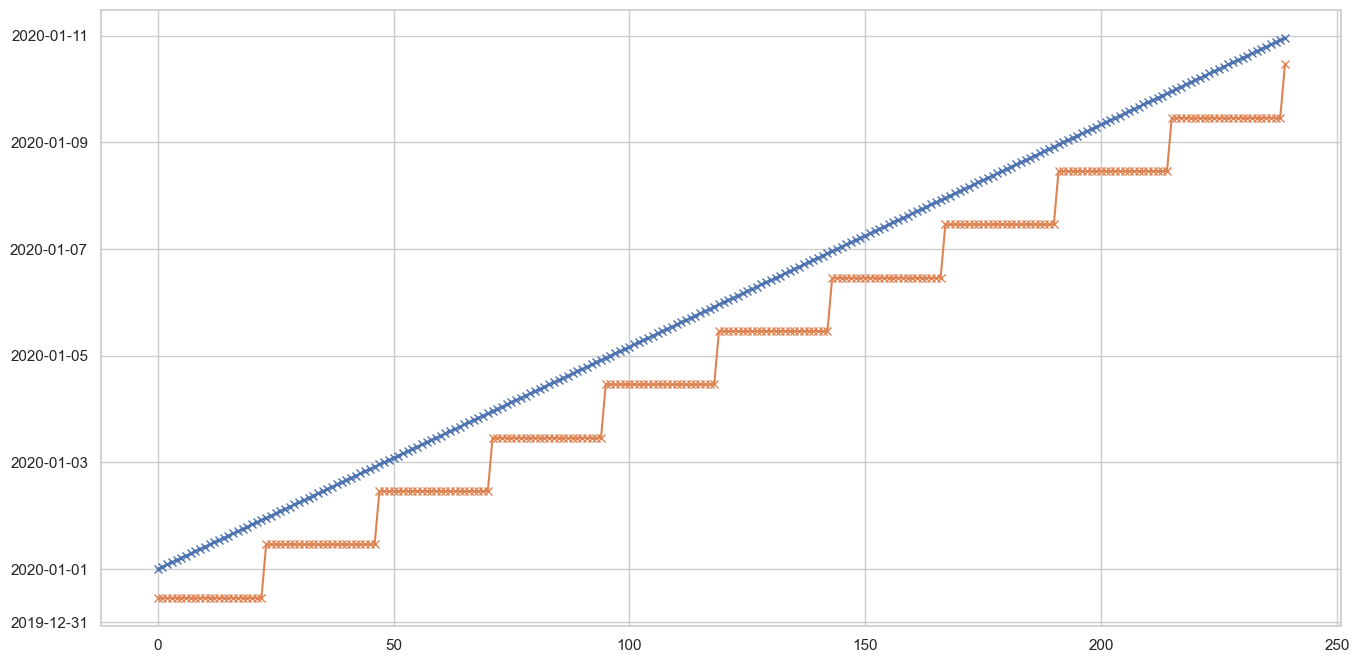

In [180]:
plt.plot(df['contract-delivery'][0:240],'x-')
plt.plot(df['day-ahead-auction-time'][0:240], 'x-')

## Initial Date, Final Date and missing timestamps

In [181]:
# Get initial and final dates  
initial_date = df["contract-delivery"].min()  
final_date = df["contract-delivery"].max()  

# Generate complete date range (assuming hourly intervals)  
all_dates = pd.date_range(start=initial_date, end=final_date, freq="h")  

# Find missing timestamps  
missing_dates = set(all_dates) - set(df["contract-delivery"])  

# Convert to sorted list  
missing_dates = sorted(missing_dates)  

# Print results  
print(f"Initial Date: {initial_date}")  
print(f"Final Date: {final_date}")  
print(f"Total Missing Timestamps: {len(missing_dates)}")  
if missing_dates:
    print("Missing Dates:")
    for date in missing_dates[:10]:  # Show first 10 missing timestamps
        print(date)
    if len(missing_dates) > 10:
        print("... (more missing timestamps not shown)")

Initial Date: 2020-01-01 00:00:00+00:00
Final Date: 2024-12-31 22:00:00+00:00
Total Missing Timestamps: 0


# EDA

## Feature time signals

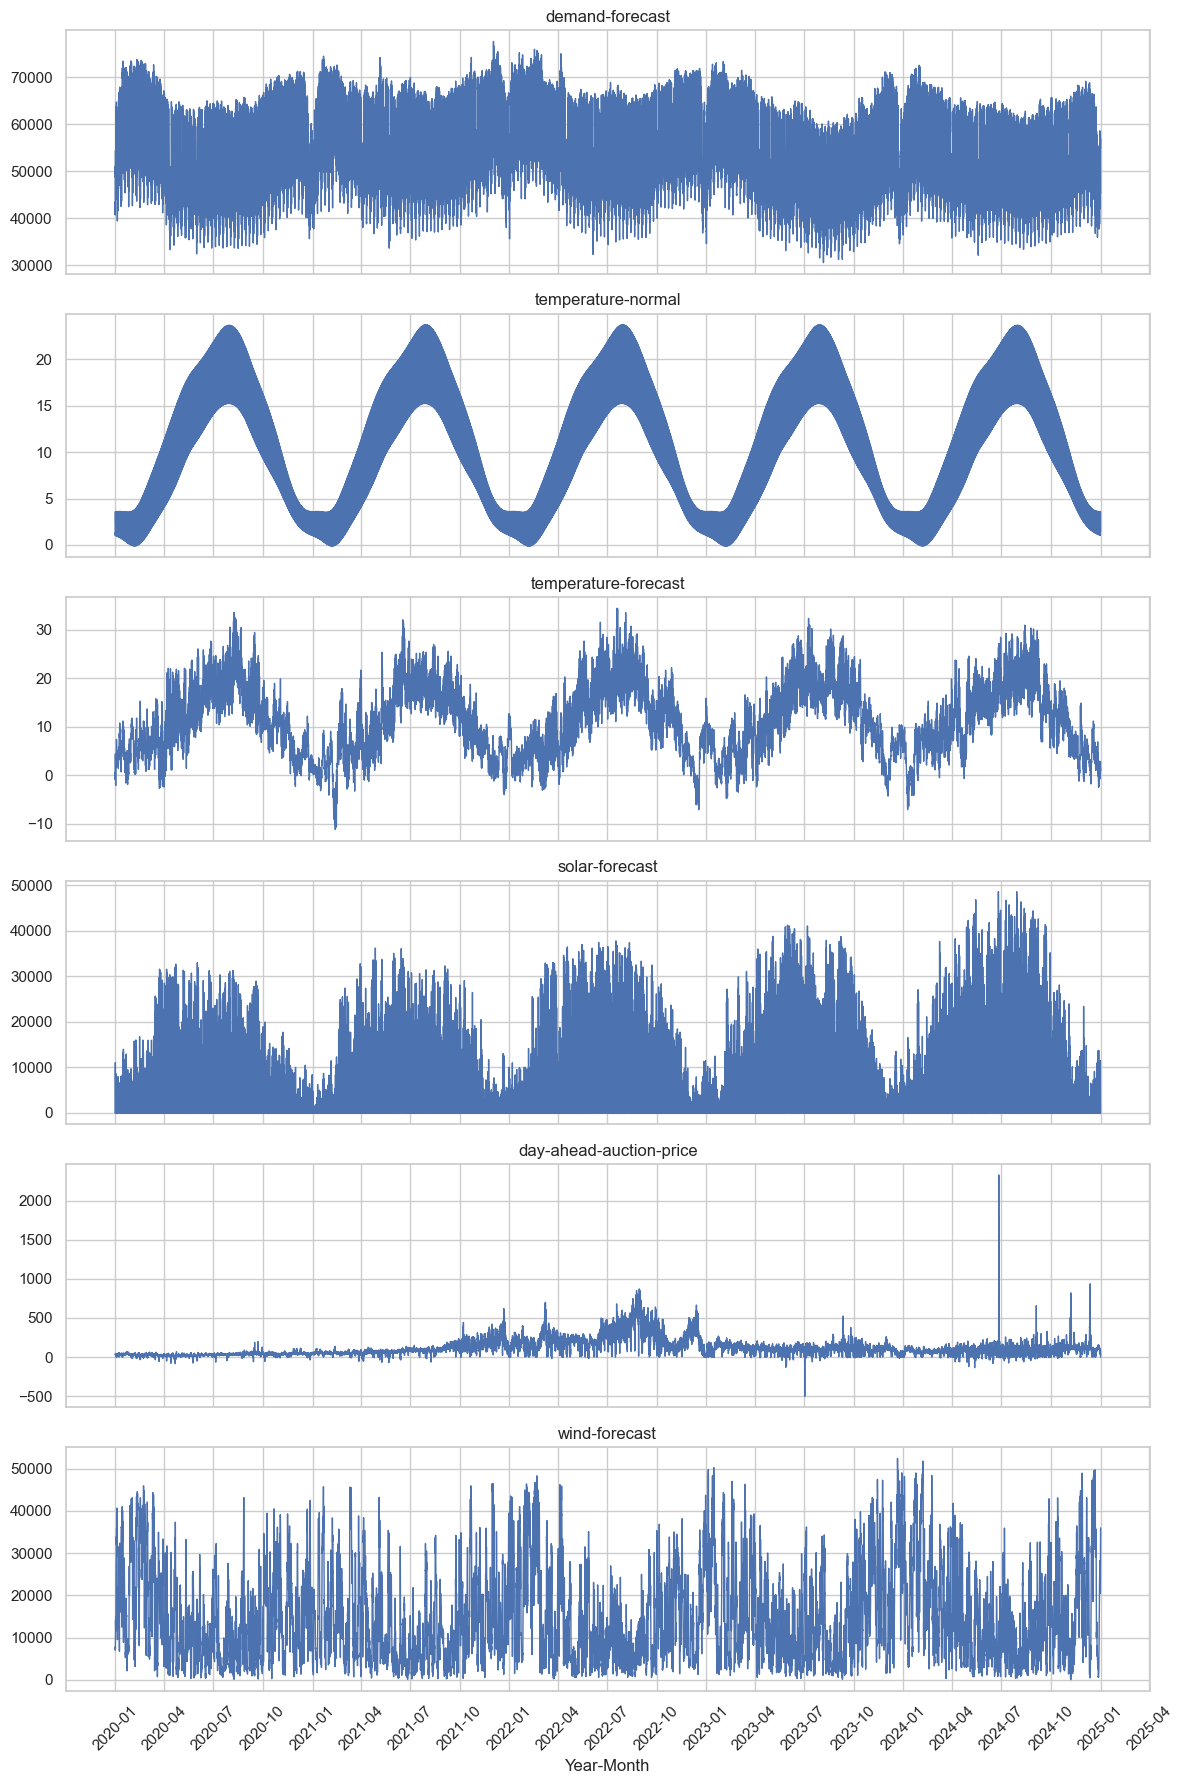

In [188]:
# Set "contract-delivery" as the index
df_plots = df.set_index("contract-delivery")

# Drop "day-ahead-auction-time"
df_plots = df_plots.drop(columns=["day-ahead-auction-time"], errors="ignore")

# Define number of variables
num_vars = len(df_plots.columns)

# Create vertical subplots
fig, axes = plt.subplots(nrows=num_vars, ncols=1, figsize=(12, 3 * num_vars), sharex=True)

# Plot each variable
for i, col in enumerate(df_plots.columns):
    axes[i].plot(df_plots.index, df_plots[col], label=col, linewidth=1)
    axes[i].set_title(col)
    axes[i].grid(True)

# Format X-axis as Year-Month
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
axes[-1].xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show every 3 months

plt.xticks(rotation=45)  # Rotate for better visibility
plt.xlabel("Year-Month")  # Common X-axis label
plt.tight_layout()
plt.show()

## Feature Distributions

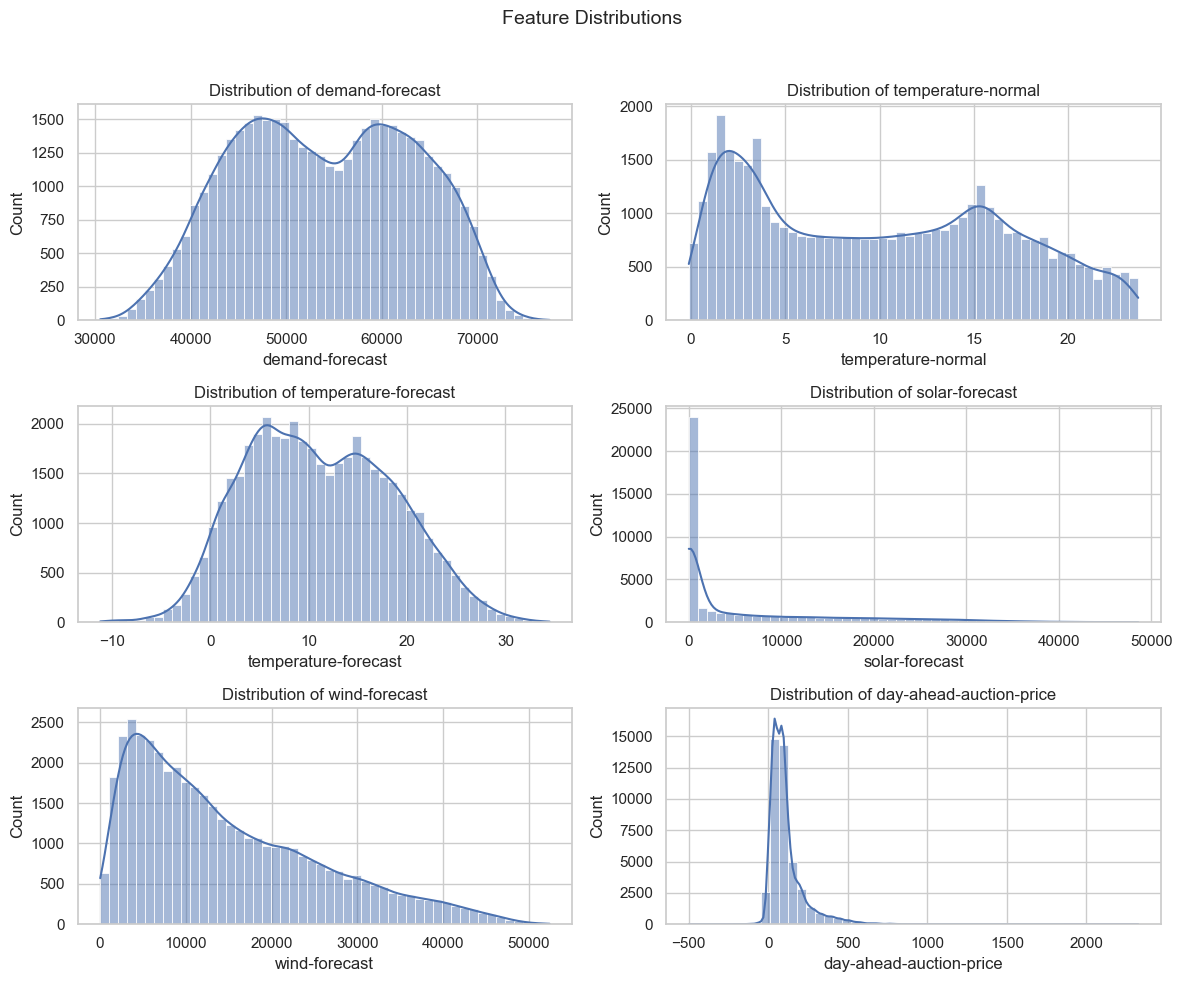

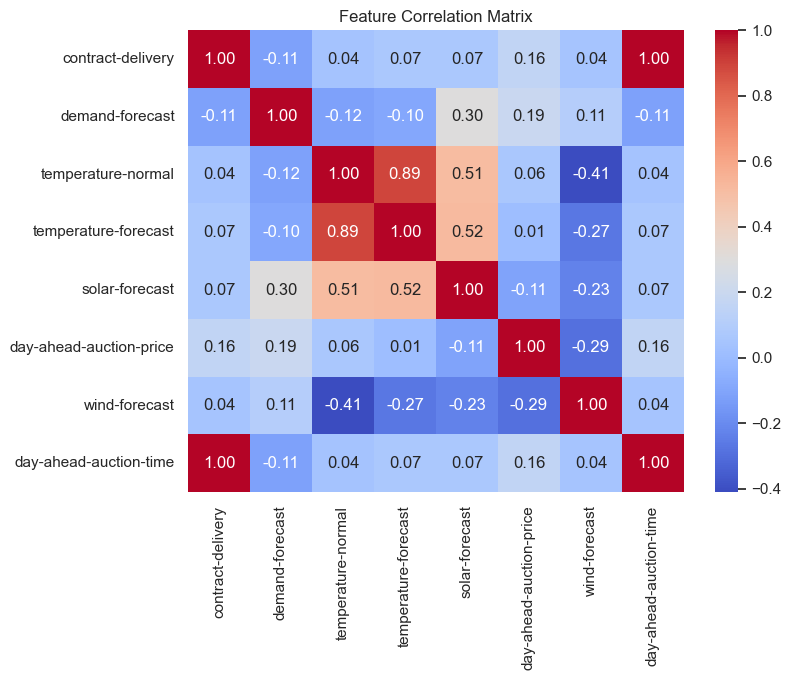

(       demand-forecast  temperature-normal  temperature-forecast  \
 count     43847.000000        43847.000000          43847.000000   
 mean      54168.834658           10.027417             11.171371   
 std        9232.674783            6.724638              7.429299   
 min       30544.750000           -0.119118            -11.200000   
 25%       46634.625000            3.528642              5.400000   
 50%       54049.250000            9.707157             10.600000   
 75%       61762.125000           15.601056             16.800000   
 max       77585.750000           23.704306             34.500000   
 
        solar-forecast  day-ahead-auction-price  wind-forecast  
 count    43847.000000             43847.000000   43847.000000  
 mean      6110.825530               107.447477   14793.633972  
 std       9450.017605               105.707266   10952.121262  
 min          0.000000              -500.000000      46.500000  
 25%          1.500000                41.350000    5

In [189]:
import matplotlib.pyplot as plt
import seaborn as sns

# Summary statistics
summary_stats = df.describe()

# Check for missing values
missing_values = df.isnull().sum()

# Correlation matrix
correlation_matrix = df.corr()

# Plot distributions of numerical features
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
fig.suptitle("Feature Distributions", fontsize=14)
numerical_cols = ["demand-forecast", "temperature-normal", "temperature-forecast",
                  "solar-forecast", "wind-forecast", "day-ahead-auction-price"]

for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], bins=50, kde=True, ax=axes[i // 2, i % 2])
    axes[i // 2, i % 2].set_title(f"Distribution of {col}")

plt.tight_layout(rect=[0, 0, 1, 0.96])

# Heatmap of correlations
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")

# Show plots
plt.show()

summary_stats, missing_values


<style>
r { color: Red }
o { color: Orange }
g { color: Green }
</style>

## EDA Findings

No Missing Values – All columns are complete.
Feature Distributions:
*   🟢 **temperature-normal** and **temperature-forecast** follow a bell curve, as expected.
*    **solar-forecast** has many zeros, likely due to nighttime hours.
*   🔴 **solar-forecast**, **wind-forecast**, **day-ahead-auction-price** are left-skewed, could be transformed to Gaussian
*   🔴 **day-ahead-auction-price** has extreme outliers (-500 to 2325 EUR).

Correlation Analysis:
*    **demand-forecast** has a <span style="color:green">*moderate positive*</span> correlation with **price**.
*    **solar-forecast** and **wind-forecast** are <span style="color:red">*negatively*</span> correlated with **price** (higher renewable generation might lower prices).
*    **Temperature** features show <span style="color:green">*low correlation*</span> with **price**.


# Target Variable: Periodicities

## Signal Decomposition

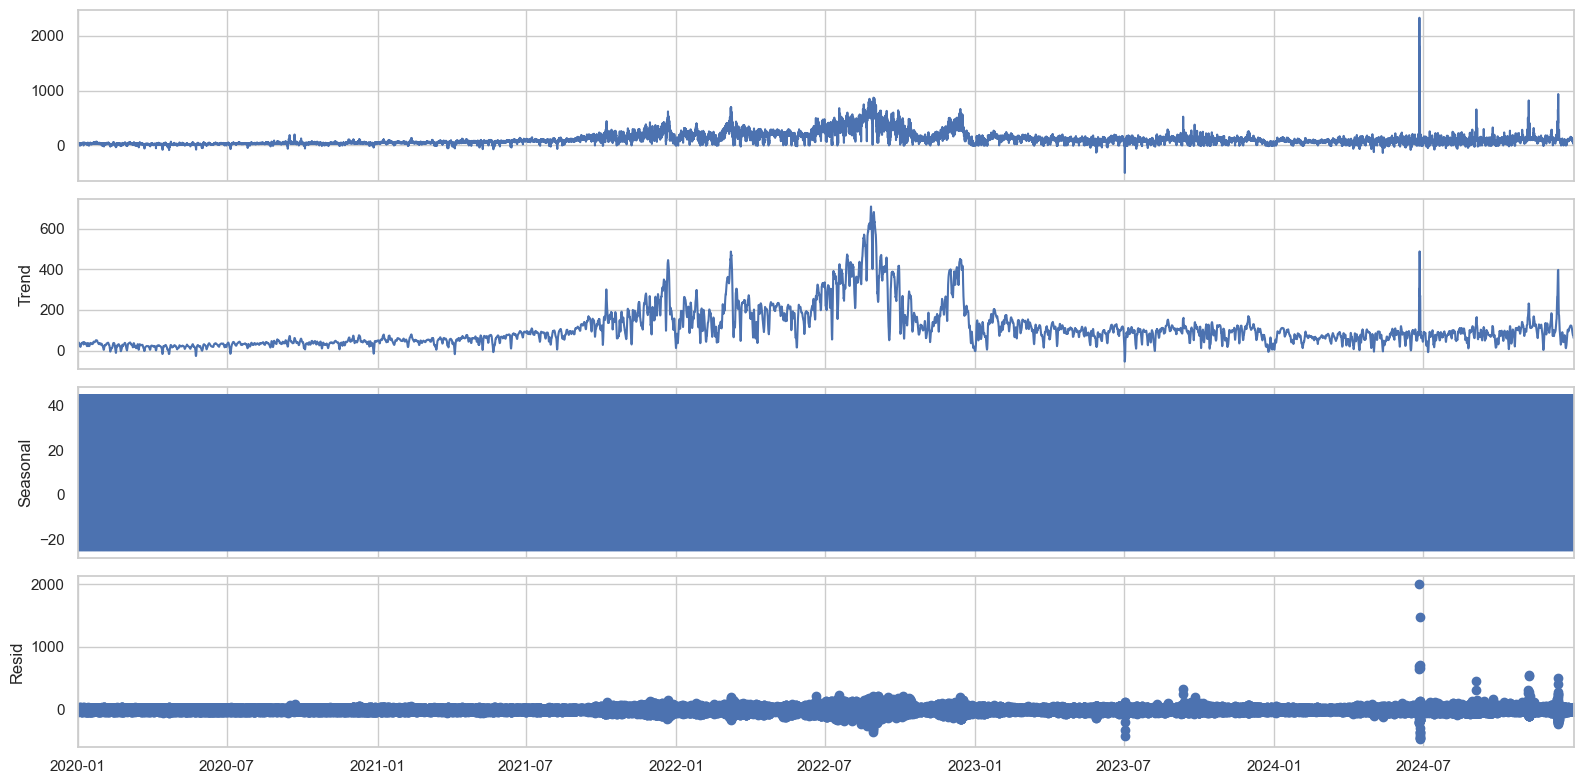

In [144]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.rcParams["figure.figsize"] = (16, 8)
seasonal_decompose(df[["contract-delivery", "day-ahead-auction-price"]].set_index("contract-delivery")).plot()
plt.show();

## Price Autocorrelation

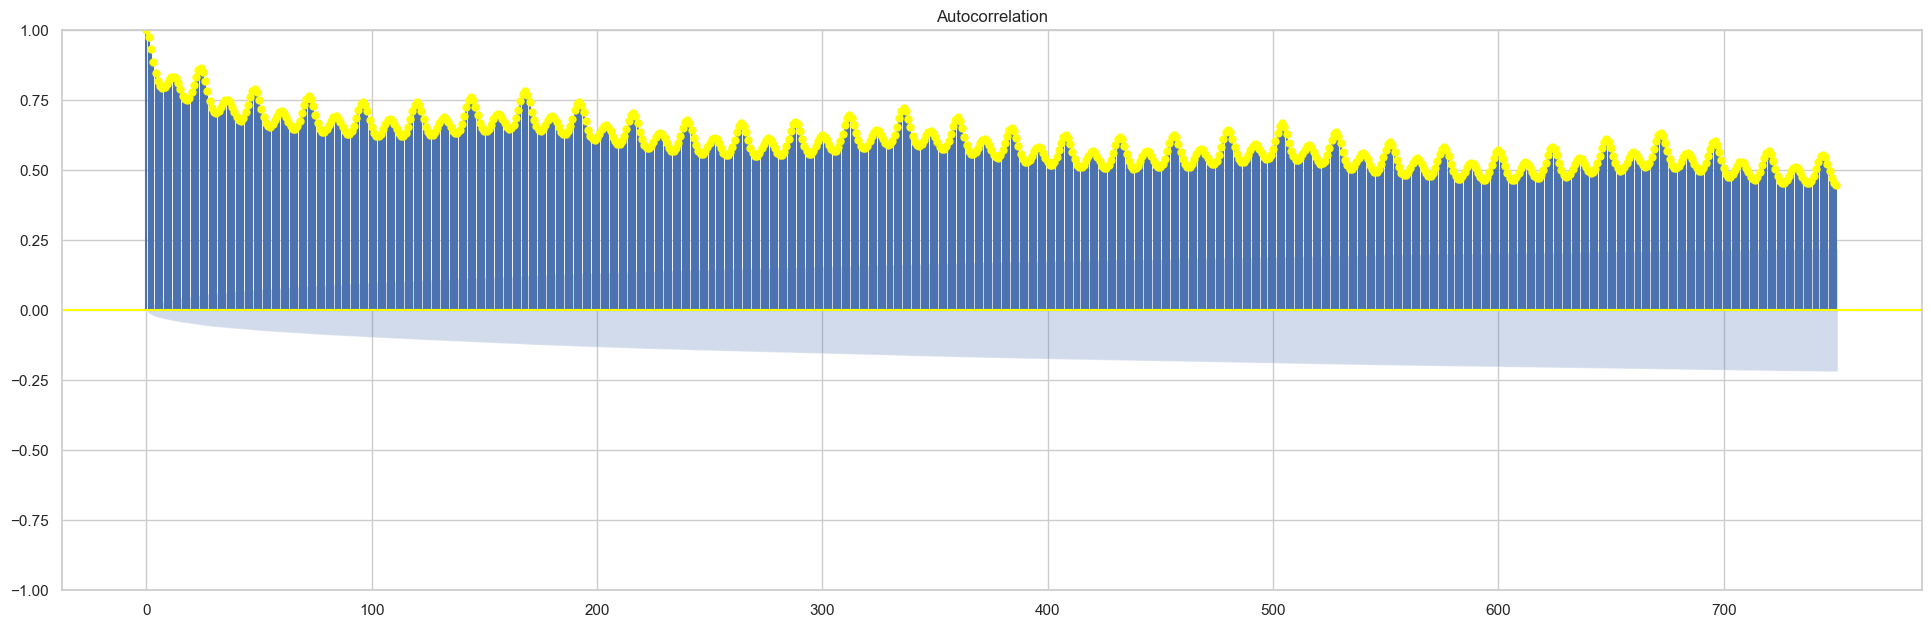

In [146]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def subplots_acf(series):
    fig1 = plt.figure(figsize=(24,16))
    ax1 = fig1.add_subplot(211)
    fig1 = plot_acf(series, lags=750, ax=ax1, color='yellow')
    plt.show()


dx = df[["contract-delivery", "day-ahead-auction-price"]].set_index("contract-delivery")
subplots_acf(dx)



## Price Fourier Transform

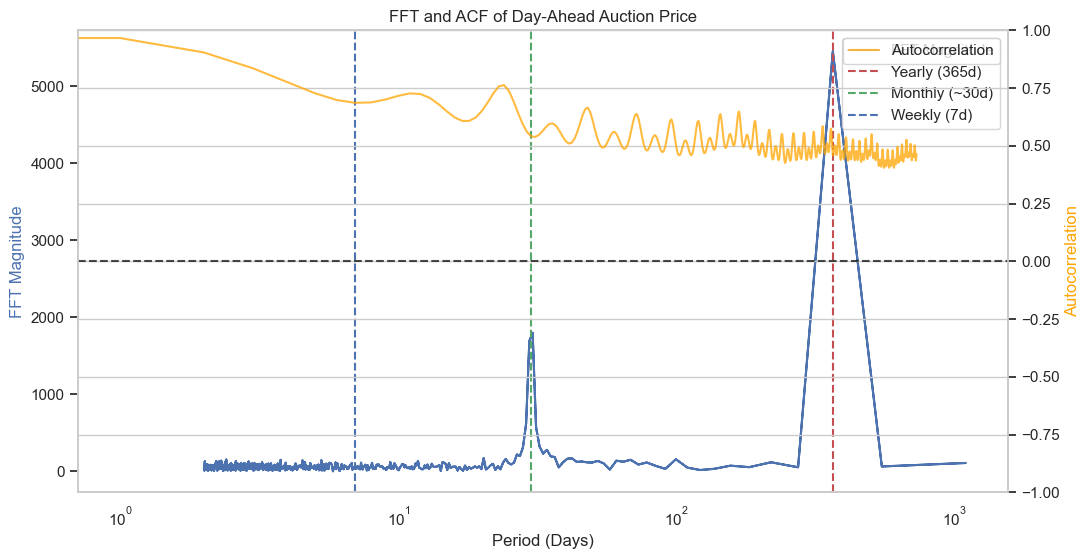

In [151]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import acf

price = df["day-ahead-auction-price"].values
# Compute ACF (Autocorrelation Function)
lags = 365 * 2  # Up to 2 years of lags
autocorr_values = acf(price, nlags=lags, fft=True)

# Plot FFT and ACF together
fig, ax1 = plt.subplots(figsize=(12, 6))

# FFT Plot
ax1.plot(periods, np.abs(fft_values[1:]), label="FFT Magnitude", color="b")
ax1.set_xscale("log")
ax1.set_xlabel("Period (Days)")
ax1.set_ylabel("FFT Magnitude", color="b")
ax1.axvline(x=365, color="r", linestyle="--", label="Yearly (365d)")
ax1.axvline(x=30, color="g", linestyle="--", label="Monthly (~30d)")
ax1.axvline(x=7, color="b", linestyle="--", label="Weekly (7d)")
ax1.legend(loc="upper right")
ax1.grid()

# ACF Plot (Second Y-Axis)
ax2 = ax1.twinx()
ax2.plot(range(lags + 1), autocorr_values, label="Autocorrelation", color="orange", alpha=0.75)
ax2.set_ylabel("Autocorrelation", color="orange")
ax2.set_ylim([-1, 1])
ax2.axhline(0, linestyle="--", color="black", alpha=0.7)

# Title
plt.title("FFT and ACF of Day-Ahead Auction Price")
plt.legend()
plt.show()


## Hourly Fourier Analysis

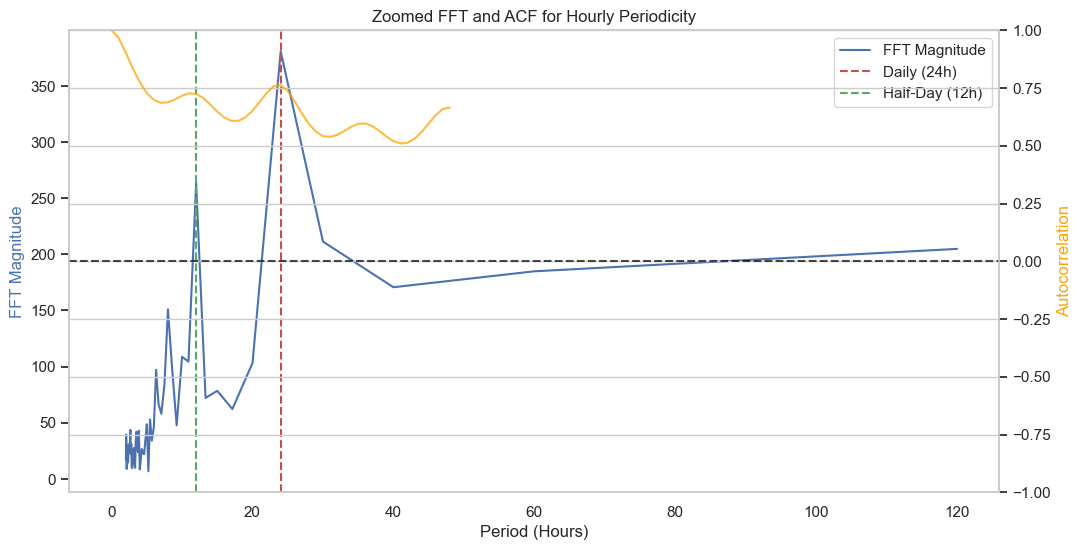

In [158]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft
from statsmodels.tsa.stattools import acf

# Assuming `price` is your time series data

# Compute FFT
N = len(price[0:120])
fft_values = fft(price[0:120])
frequencies = np.fft.fftfreq(N, d=1)  # d=1 assumes hourly data

# Convert frequencies to hours
periods_hours = 1 / frequencies[1:N//2]  # Ignore the zero frequency

# Compute ACF (Autocorrelation Function)
hourly_lags = 48  # Up to 48-hour lags
autocorr_hourly = acf(price, nlags=hourly_lags, fft=True)

# Plot FFT Spectrum (Hourly)
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(periods_hours, np.abs(fft_values[1:N//2]), label="FFT Magnitude", color="b")
ax1.set_xscale("linear")
ax1.set_xlabel("Period (Hours)")
ax1.set_ylabel("FFT Magnitude", color="b")
ax1.set_title("Zoomed FFT and ACF for Hourly Periodicity")
ax1.axvline(x=24, color="r", linestyle="--", label="Daily (24h)")
ax1.axvline(x=12, color="g", linestyle="--", label="Half-Day (12h)")
ax1.legend()
ax1.grid()

# ACF for Hourly Periodicity (Second Y-Axis)
ax2 = ax1.twinx()
ax2.plot(range(hourly_lags + 1), autocorr_hourly, label="Autocorrelation", color="orange", alpha=0.75)
ax2.set_ylabel("Autocorrelation", color="orange")
ax2.set_ylim([-1, 1])
ax2.axhline(0, linestyle="--", color="black", alpha=0.7)

plt.show()


# Target Variable: Negative Prices and Outliers

Should we use outliers?

- 👉 For daily price forecasting: Remove/Smooth outliers for a smoother trend.
- For risk management & extreme events: Keep outliers to model shock events.

See notebook 02_Outlier_Analysis.ipynb for more details.

In [35]:
# Handling outliers in day-ahead-auction-price
# Define an outlier threshold using IQR
Q1 = df["day-ahead-auction-price"].quantile(0.25)
Q3 = df["day-ahead-auction-price"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers based on IQR thresholds
df_cleaned = df[(df["day-ahead-auction-price"] >= lower_bound) & 
                (df["day-ahead-auction-price"] <= upper_bound)]

# Display IQR-based outlier thresholds
lower_bound, upper_bound


(-91.18625000000003, 262.24375000000003)

Negative Prices?
When wind and solar production is very high, especially during low demand periods power producers may still generate electricity because:
- Wind and solar farms receive subsidies or contracts that make it more beneficial to continue producing.
- <strong> Shutting down production might be costlier than selling at a negative price.</strong>

## Negative prices analisys

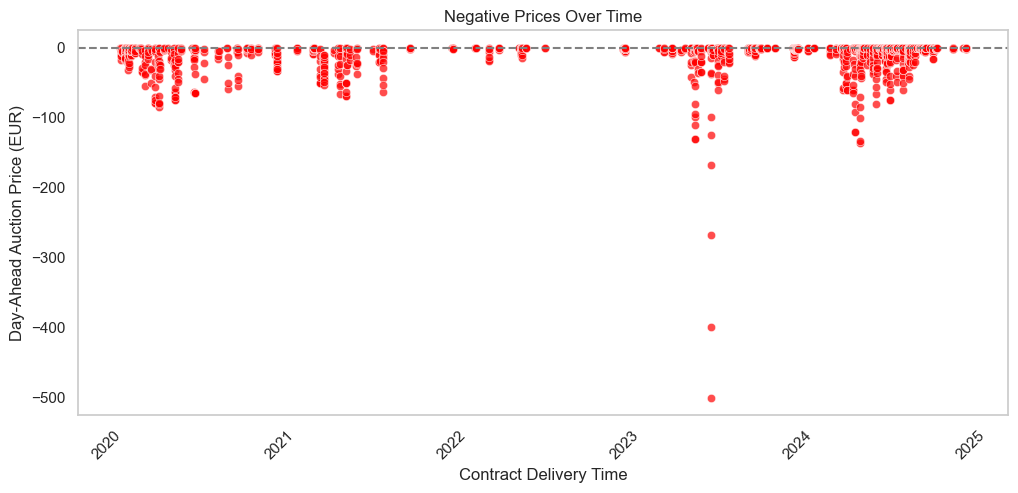

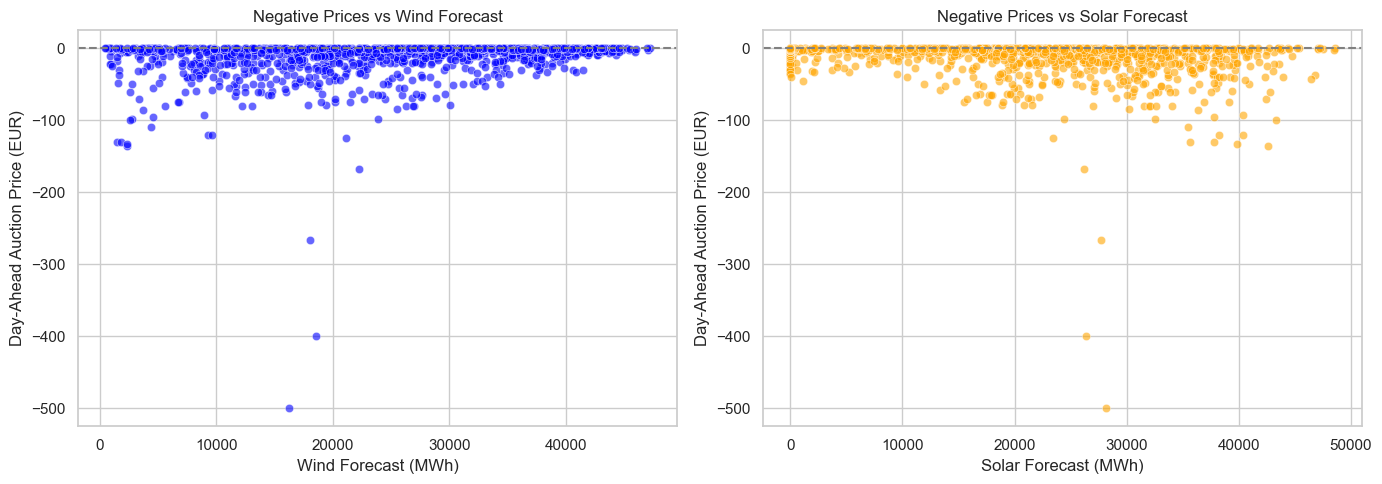

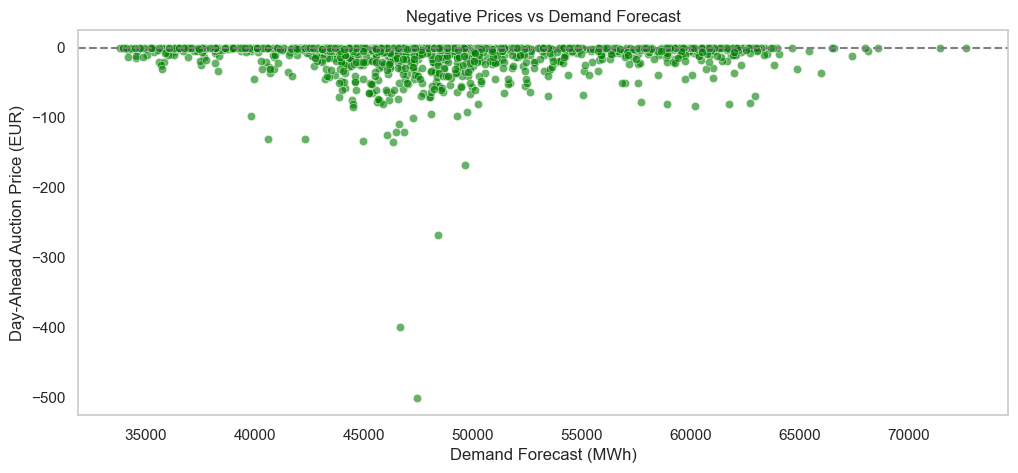

In [47]:
# Filter negative prices
df_negative = df[df["day-ahead-auction-price"] < 0]

# Plot 1: Negative Prices Over Time
plt.figure(figsize=(12, 5))
sns.scatterplot(data=df_negative, x="contract-delivery", y="day-ahead-auction-price", color="red", alpha=0.7)
plt.axhline(0, linestyle="--", color="gray")
plt.title("Negative Prices Over Time")
plt.xlabel("Contract Delivery Time")
plt.ylabel("Day-Ahead Auction Price (EUR)")
plt.xticks(rotation=45)
plt.grid()
plt.show()

# Plot 2: Negative Prices vs Wind & Solar Generation
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Wind Production vs Price
sns.scatterplot(data=df_negative, x="wind-forecast", y="day-ahead-auction-price", ax=ax[0], color="blue", alpha=0.6)
ax[0].set_title("Negative Prices vs Wind Forecast")
ax[0].set_xlabel("Wind Forecast (MWh)")
ax[0].set_ylabel("Day-Ahead Auction Price (EUR)")
ax[0].axhline(0, linestyle="--", color="gray")

# Solar Production vs Price
sns.scatterplot(data=df_negative, x="solar-forecast", y="day-ahead-auction-price", ax=ax[1], color="orange", alpha=0.6)
ax[1].set_title("Negative Prices vs Solar Forecast")
ax[1].set_xlabel("Solar Forecast (MWh)")
ax[1].set_ylabel("Day-Ahead Auction Price (EUR)")
ax[1].axhline(0, linestyle="--", color="gray")

plt.tight_layout()
plt.show()

# Plot 3: Negative Prices vs Demand Forecast
plt.figure(figsize=(12, 5))
sns.scatterplot(data=df_negative, x="demand-forecast", y="day-ahead-auction-price", color="green", alpha=0.6)
plt.axhline(0, linestyle="--", color="gray")
plt.title("Negative Prices vs Demand Forecast")
plt.xlabel("Demand Forecast (MWh)")
plt.ylabel("Day-Ahead Auction Price (EUR)")
plt.grid()
plt.show()

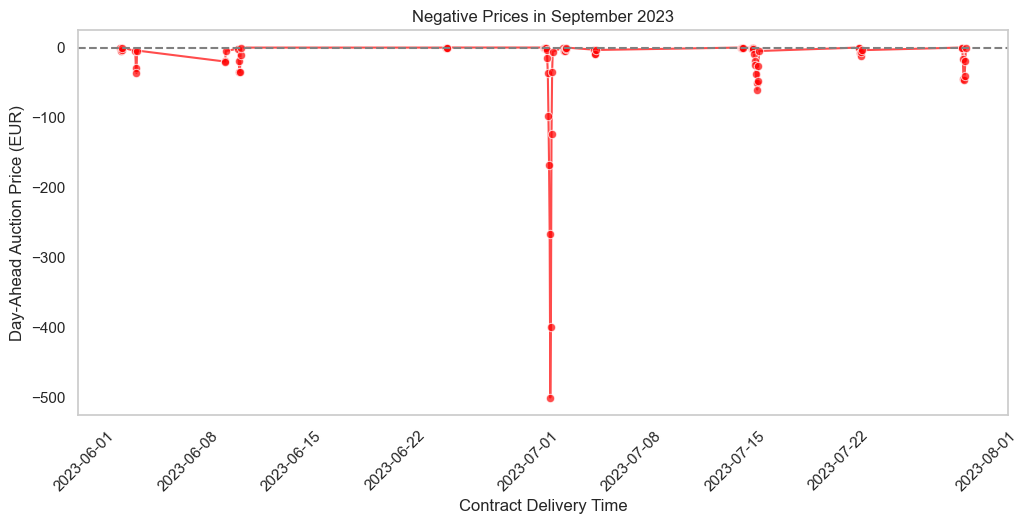

In [53]:
df_sept_2023 = df_negative[(df_negative["contract-delivery"] >= "2023-06-01") & 
                            (df_negative["contract-delivery"] < "2023-08-01")]

# Plot negative prices in Sept 2023
plt.figure(figsize=(12, 5))
sns.lineplot(data=df_sept_2023, x="contract-delivery", y="day-ahead-auction-price", marker="o", color="red", alpha=0.7)
plt.axhline(0, linestyle="--", color="gray")
plt.title("Negative Prices in September 2023")
plt.xlabel("Contract Delivery Time")
plt.ylabel("Day-Ahead Auction Price (EUR)")
plt.xticks(rotation=45)
plt.grid()
plt.show()


## Possitive outliers analysis

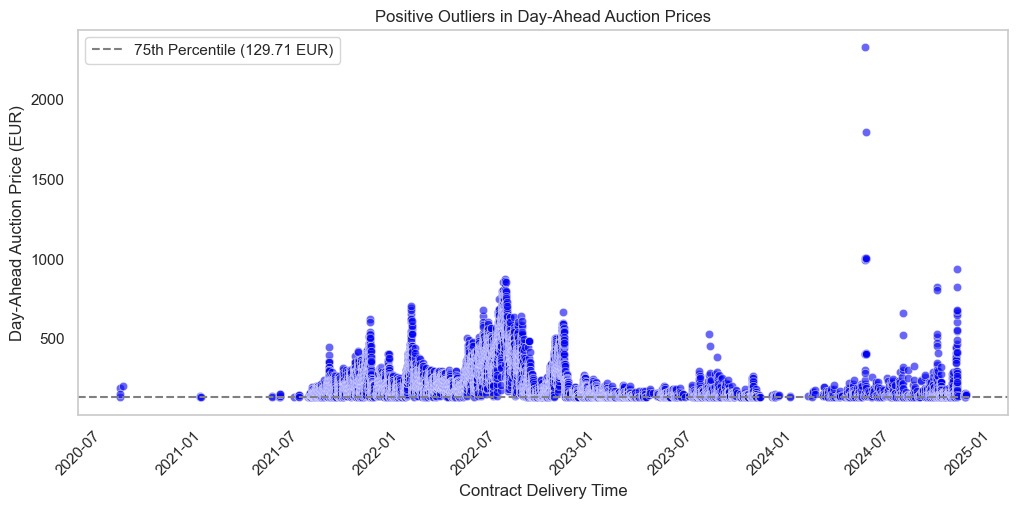

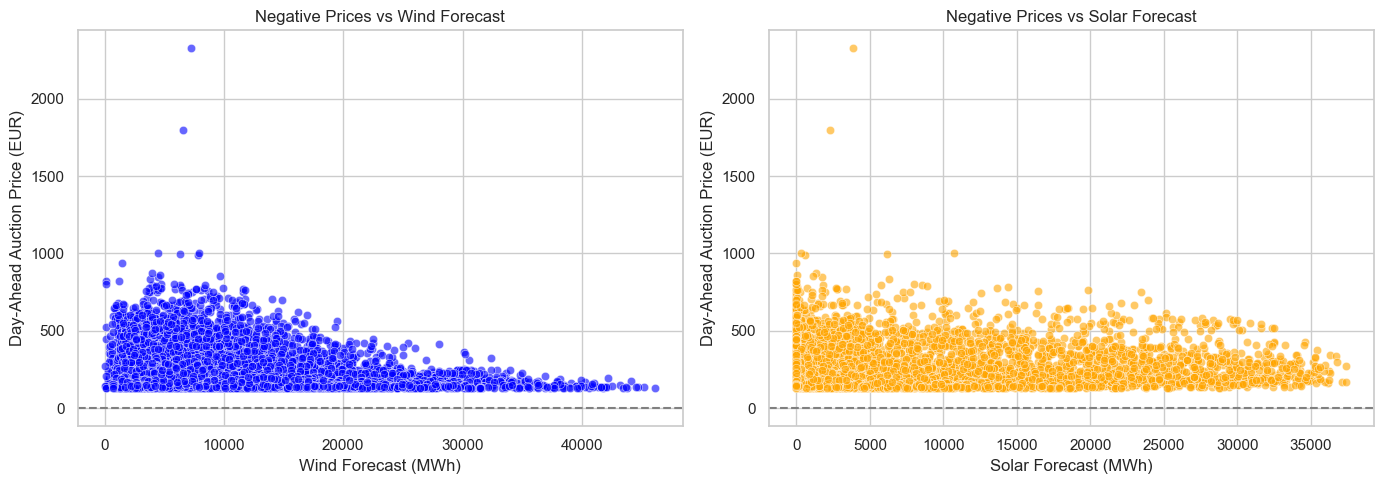

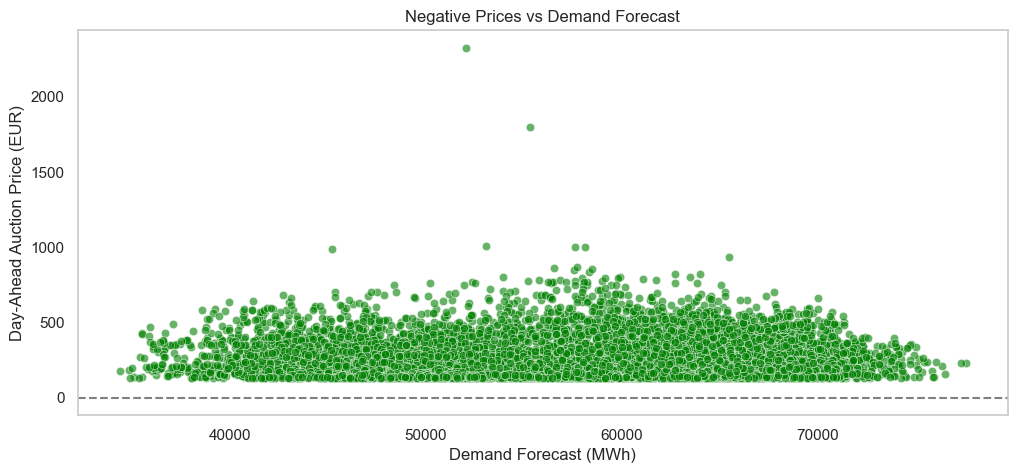

In [57]:
# Define a threshold for positive outliers (e.g., above the 95th percentile)
positive_threshold = Q3 #df["day-ahead-auction-price"].quantile(0.95)
df_positive_outliers = df[df["day-ahead-auction-price"] > positive_threshold]

# Plot the positive outliers over time
plt.figure(figsize=(12, 5))
sns.scatterplot(data=df_positive_outliers, x="contract-delivery", y="day-ahead-auction-price", color="blue", alpha=0.6)
plt.axhline(positive_threshold, linestyle="--", color="gray", label=f"75th Percentile ({positive_threshold:.2f} EUR)")
plt.title("Positive Outliers in Day-Ahead Auction Prices")
plt.xlabel("Contract Delivery Time")
plt.ylabel("Day-Ahead Auction Price (EUR)")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()


# Plot 2: Negative Prices vs Wind & Solar Generation
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Wind Production vs Price
sns.scatterplot(data=df_positive_outliers, x="wind-forecast", y="day-ahead-auction-price", ax=ax[0], color="blue", alpha=0.6)
ax[0].set_title("Negative Prices vs Wind Forecast")
ax[0].set_xlabel("Wind Forecast (MWh)")
ax[0].set_ylabel("Day-Ahead Auction Price (EUR)")
ax[0].axhline(0, linestyle="--", color="gray")

# Solar Production vs Price
sns.scatterplot(data=df_positive_outliers, x="solar-forecast", y="day-ahead-auction-price", ax=ax[1], color="orange", alpha=0.6)
ax[1].set_title("Negative Prices vs Solar Forecast")
ax[1].set_xlabel("Solar Forecast (MWh)")
ax[1].set_ylabel("Day-Ahead Auction Price (EUR)")
ax[1].axhline(0, linestyle="--", color="gray")

plt.tight_layout()
plt.show()

# Plot 3: Negative Prices vs Demand Forecast
plt.figure(figsize=(12, 5))
sns.scatterplot(data=df_positive_outliers, x="demand-forecast", y="day-ahead-auction-price", color="green", alpha=0.6)
plt.axhline(0, linestyle="--", color="gray")
plt.title("Negative Prices vs Demand Forecast")
plt.xlabel("Demand Forecast (MWh)")
plt.ylabel("Day-Ahead Auction Price (EUR)")
plt.grid()
plt.show()


# Target Variable: Seasonality Distribution

In [193]:
# Feature Engineering: Extracting time-based features
# More feature engineering in separate notebook, but we need this here.
df["hour"] = df["contract-delivery"].dt.hour
df["day_of_week"] = df["contract-delivery"].dt.dayofweek
df["month"] = df["contract-delivery"].dt.month

## Box-plots: Distribution by Month, Day-of-Week, Hour

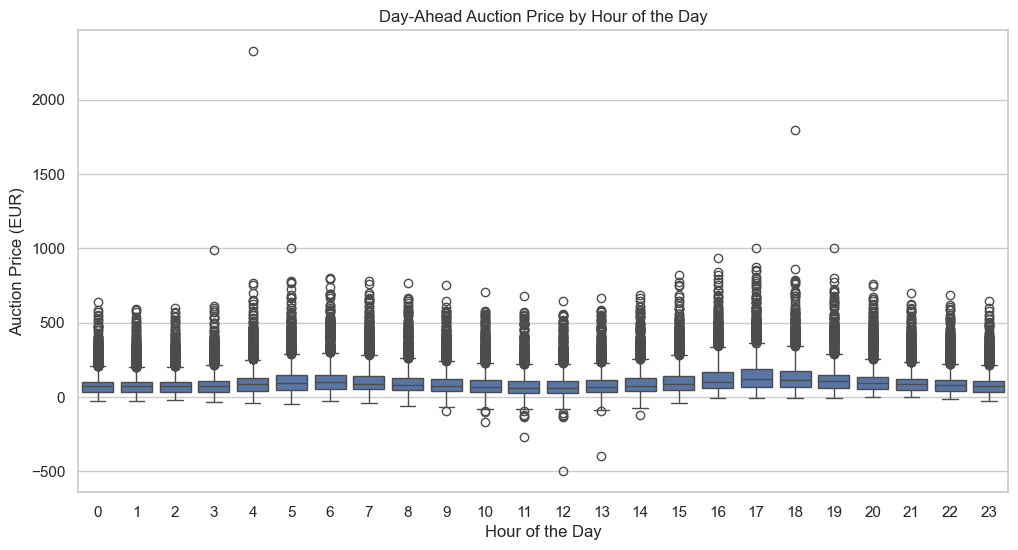

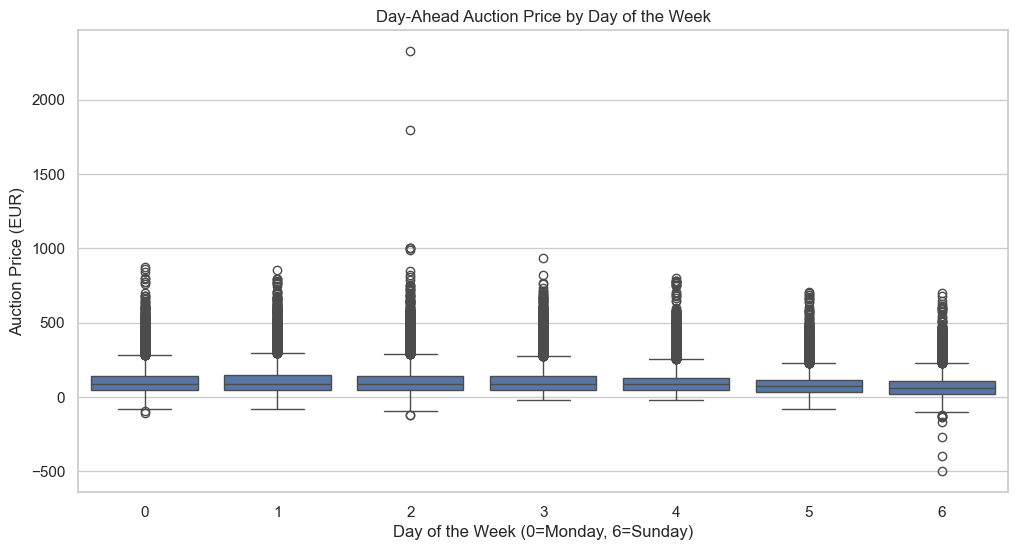

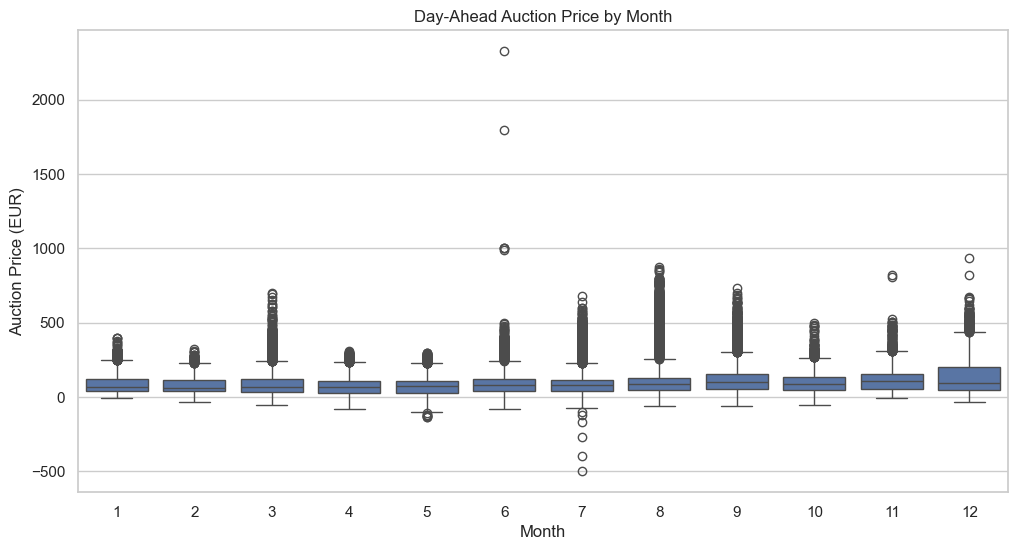

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns


# Boxplot to visualize price distribution by hour
plt.figure(figsize=(12, 6))
sns.boxplot(x=df["hour"], y=df["day-ahead-auction-price"])
plt.title("Day-Ahead Auction Price by Hour of the Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Auction Price (EUR)")
plt.show()

# Boxplot to visualize price by day of the week
plt.figure(figsize=(12, 6))
sns.boxplot(x=df["day_of_week"], y=df["day-ahead-auction-price"])
plt.title("Day-Ahead Auction Price by Day of the Week")
plt.xlabel("Day of the Week (0=Monday, 6=Sunday)")
plt.ylabel("Auction Price (EUR)")
plt.show()

# Boxplot to visualize price by day of the week
plt.figure(figsize=(12, 6))
sns.boxplot(x=df["month"], y=df["day-ahead-auction-price"])
plt.title("Day-Ahead Auction Price by Month")
plt.xlabel("Month")
plt.ylabel("Auction Price (EUR)")
plt.show()

## Line plots: Trend by Month, day-of-Week, Hour

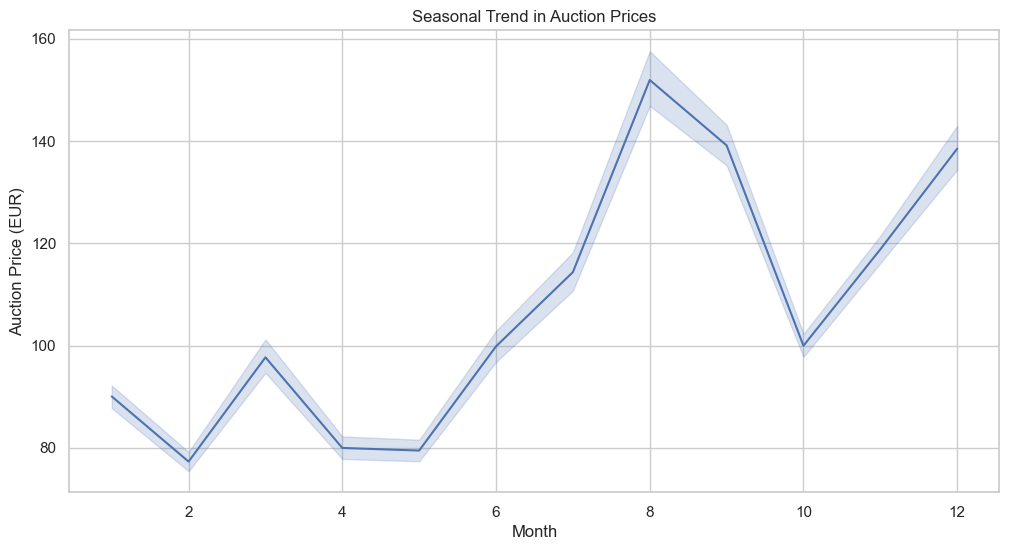

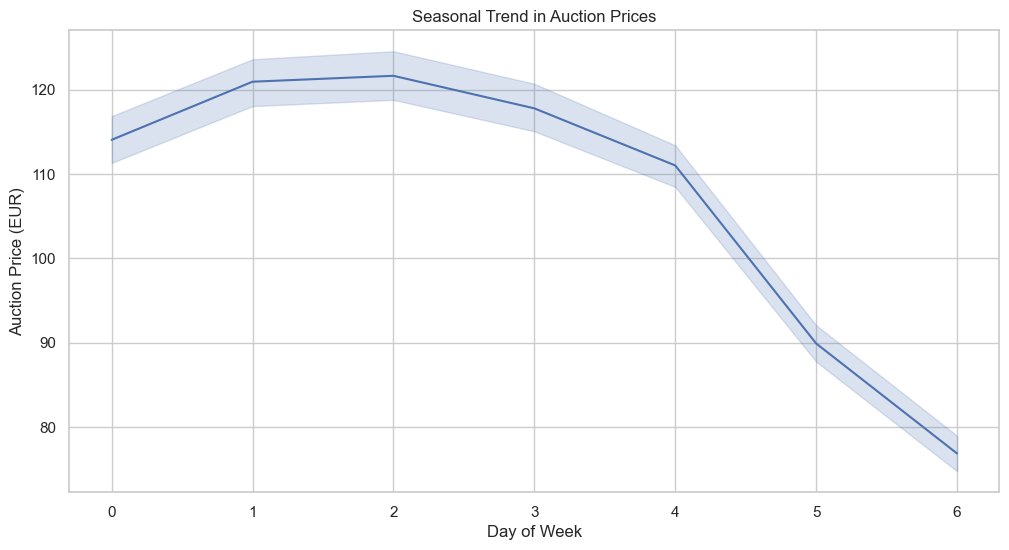

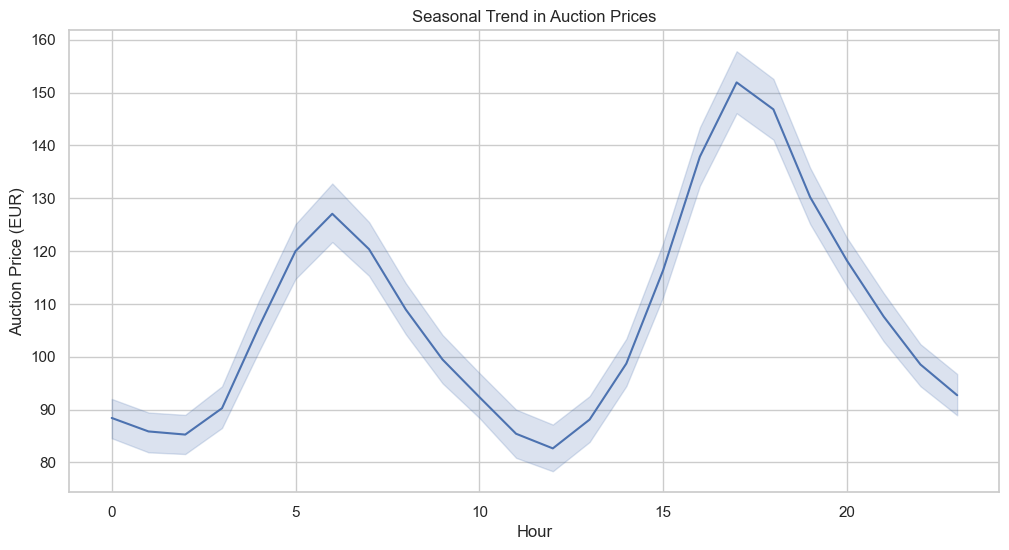

In [70]:

# Checking seasonality in price trends
plt.figure(figsize=(12, 6))
sns.lineplot(x=df["month"], y=df["day-ahead-auction-price"])
plt.title("Seasonal Trend in Auction Prices")
plt.xlabel("Month")
plt.ylabel("Auction Price (EUR)")
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(x=df["day_of_week"], y=df["day-ahead-auction-price"])
plt.title("Seasonal Trend in Auction Prices")
plt.xlabel("Day of Week")
plt.ylabel("Auction Price (EUR)")
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(x=df["hour"], y=df["day-ahead-auction-price"])
plt.title("Seasonal Trend in Auction Prices")
plt.xlabel("Hour")
plt.ylabel("Auction Price (EUR)")
plt.show()

Findings from Feature Engineering & Visualizations

    Outliers:
        Prices below -91.18 EUR and above 262.24 EUR are considered outliers based on the IQR method.
        We may want to remove or handle these extreme values in modeling.

    Hourly Trends:
        Prices tend to fluctuate based on the hour of the day, likely reflecting demand peaks (morning/evening).

    Weekly Trends:
        Prices vary across weekdays, potentially due to differences in industrial vs. residential consumption.

    Impact of Solar & Wind Generation:
        Higher solar generation seems to correlate with lower prices (due to surplus energy).
        Wind generation also has a negative correlation with price.

    Seasonality:
        Prices show variations across months, potentially reflecting weather-driven demand changes.

Next Steps

    Build a simple baseline model (e.g., Linear Regression or historical average).
    Try different feature combinations to improve performance.

## Scatter plots: Renewable vs Price

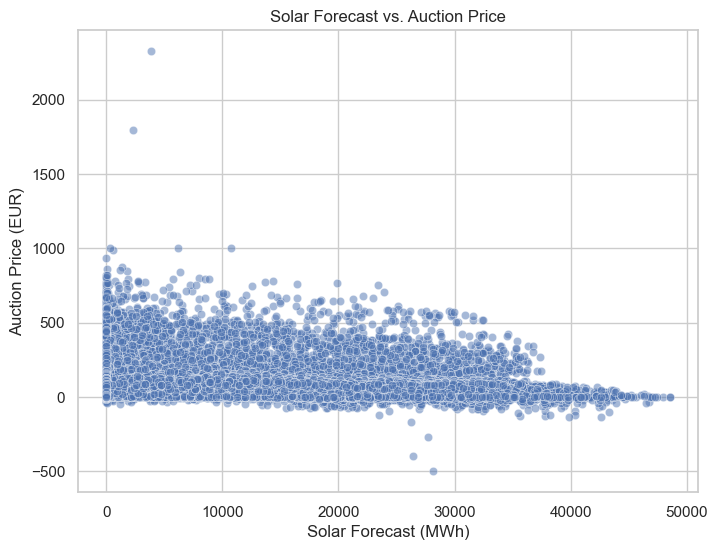

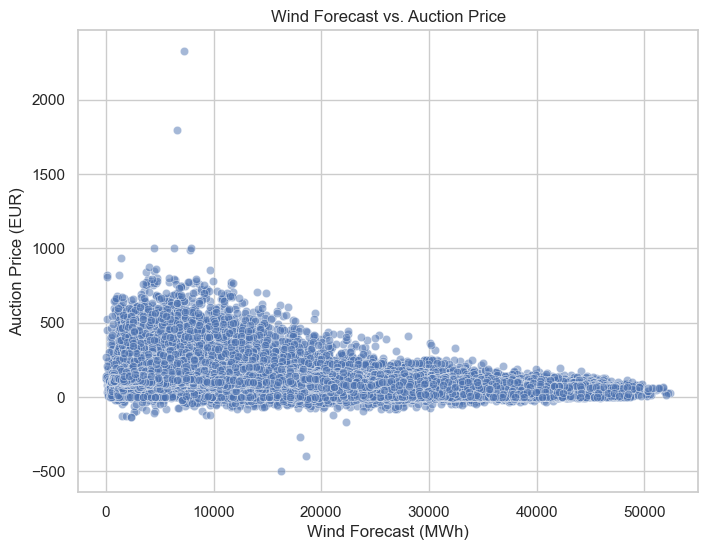

In [66]:
# Scatter plot: Solar Forecast vs. Auction Price
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df["solar-forecast"], y=df["day-ahead-auction-price"], alpha=0.5)
plt.title("Solar Forecast vs. Auction Price")
plt.xlabel("Solar Forecast (MWh)")
plt.ylabel("Auction Price (EUR)")
plt.show()

# Scatter plot: Wind Forecast vs. Auction Price
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df["wind-forecast"], y=df["day-ahead-auction-price"], alpha=0.5)
plt.title("Wind Forecast vs. Auction Price")
plt.xlabel("Wind Forecast (MWh)")
plt.ylabel("Auction Price (EUR)")
plt.show()

# Hourly Volatility in Power Markets

Hourly volatility refers to how much day-ahead auction prices fluctuate from one hour to the next. It is a key metric in power market analysis because electricity prices can change drastically due to supply and demand shifts, renewable generation variability, and market conditions.

How Do We Measure Hourly Volatility?

    Price Differences Between Consecutive Hours:
        Compute the absolute difference between the price at hour t and price at hour (t-1).
        Higher differences indicate more volatile price changes.

    Standard Deviation Within Each Hour of the Day:
        Measure the spread of prices across different days for each hour (e.g., how 2 PM prices vary over multiple days).
        A high standard deviation means prices fluctuate more at that hour.

    Coefficient of Variation (CV):
        CV = (Standard Deviation) / (Mean Price)
        Normalizes volatility across different price ranges.

Why Does Hourly Volatility Matter?

    Market Participants Use It to Manage Risk: Traders, suppliers, and consumers monitor volatility to optimize bidding strategies.
    High Volatility Indicates Uncertainty: Could be due to unexpected weather changes, demand surges, or supply shortages.
    Renewable Energy Increases Volatility: Wind and solar power fluctuate based on weather conditions, making prices more unpredictable.

## Remove outliers for Volatity Analysis?

In [191]:
do_remove_outliers = False
if do_remove_outliers:
    # Remove outliers based on IQR thresholds
    df_cleaned = df[(df["day-ahead-auction-price"] >= lower_bound) & 
                    (df["day-ahead-auction-price"] <= upper_bound)]
else:
    df_cleaned = df

## Hourly Volatility

<Figure size 1200x500 with 0 Axes>

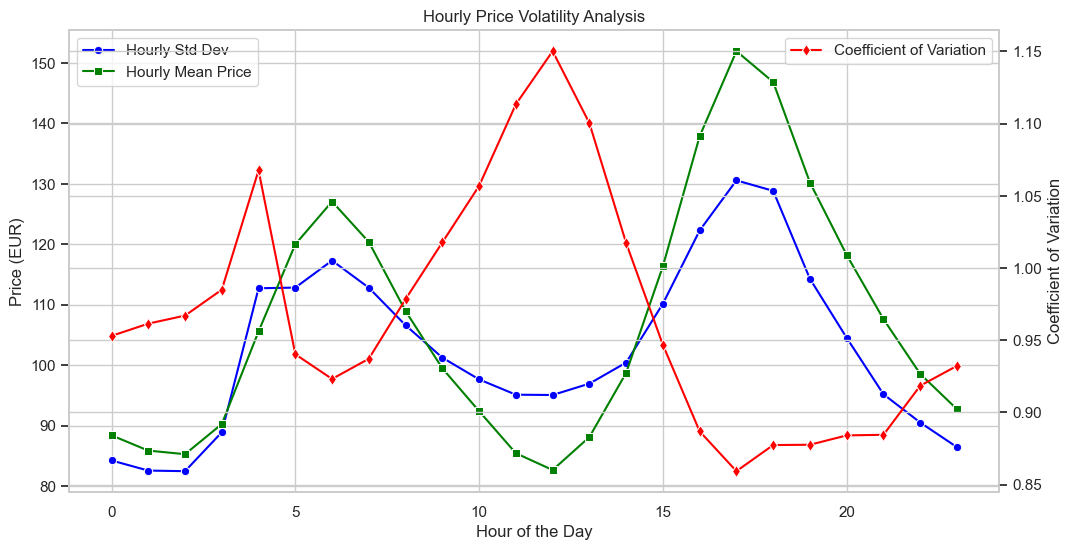

In [197]:
# Compute Hourly Statistics
hourly_volatility = df_cleaned.groupby("hour")["day-ahead-auction-price"].std()
hourly_mean = df_cleaned.groupby("hour")["day-ahead-auction-price"].mean()
cv = hourly_volatility / hourly_mean  # Coefficient of Variation

# Create DataFrame for plotting
volatility_summary = pd.DataFrame({
    "Hourly Std Dev": hourly_volatility,
    "Hourly Mean": hourly_mean,
    "Coefficient of Variation": cv
}).sort_index()

# Plot Hourly Volatility
plt.figure(figsize=(12, 5))
sns.set_theme(style="whitegrid")

fig, ax1 = plt.subplots(figsize=(12, 6))

# Standard Deviation Line
sns.lineplot(x=volatility_summary.index, y=volatility_summary["Hourly Std Dev"], marker="o", label="Hourly Std Dev", ax=ax1, color="blue")

# Mean Price Line
sns.lineplot(x=volatility_summary.index, y=volatility_summary["Hourly Mean"], marker="s", label="Hourly Mean Price", ax=ax1, color="green")

# Second y-axis for Coefficient of Variation
ax2 = ax1.twinx()
sns.lineplot(x=volatility_summary.index, y=volatility_summary["Coefficient of Variation"], marker="d", label="Coefficient of Variation", ax=ax2, color="red")

# Labels & Titles
ax1.set_xlabel("Hour of the Day")
ax1.set_ylabel("Price (EUR)")
ax2.set_ylabel("Coefficient of Variation")
ax1.set_title("Hourly Price Volatility Analysis")

# Legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()

## Relationship between wind/solar production fluctuations and price volatility.

<Figure size 1200x600 with 0 Axes>

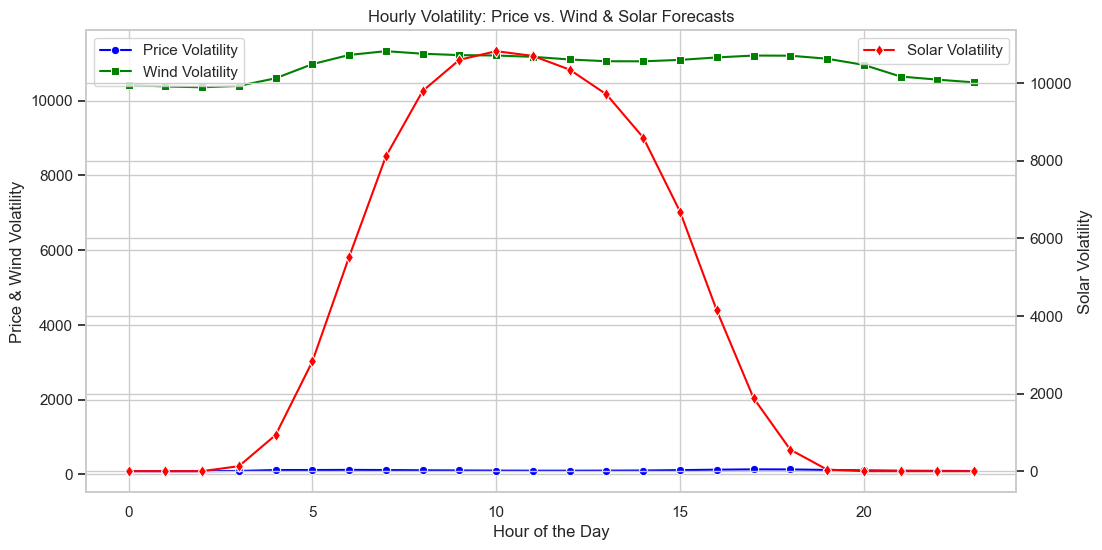

In [198]:
# Compute Hourly Volatility (Std Dev) for Wind, Solar & Price
hourly_stats = df_cleaned.groupby("hour").agg({
    "day-ahead-auction-price": "std",
    "wind-forecast": "std",
    "solar-forecast": "std"
}).rename(columns={
    "day-ahead-auction-price": "Price Volatility",
    "wind-forecast": "Wind Volatility",
    "solar-forecast": "Solar Volatility"
})

# 🔹 Plot Price vs. Wind & Solar Volatility
plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")

fig, ax1 = plt.subplots(figsize=(12, 6))

# Line plot for Price Volatility
sns.lineplot(data=hourly_stats, x=hourly_stats.index, y="Price Volatility", marker="o", label="Price Volatility", ax=ax1, color="blue")

# Line plot for Wind Volatility
sns.lineplot(data=hourly_stats, x=hourly_stats.index, y="Wind Volatility", marker="s", label="Wind Volatility", ax=ax1, color="green")

# Second y-axis for Solar Volatility
ax2 = ax1.twinx()
sns.lineplot(data=hourly_stats, x=hourly_stats.index, y="Solar Volatility", marker="d", label="Solar Volatility", ax=ax2, color="red")

# Labels & Titles
ax1.set_xlabel("Hour of the Day")
ax1.set_ylabel("Price & Wind Volatility")
ax2.set_ylabel("Solar Volatility")
ax1.set_title("Hourly Volatility: Price vs. Wind & Solar Forecasts")

# Legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()

## Nomalized to compare

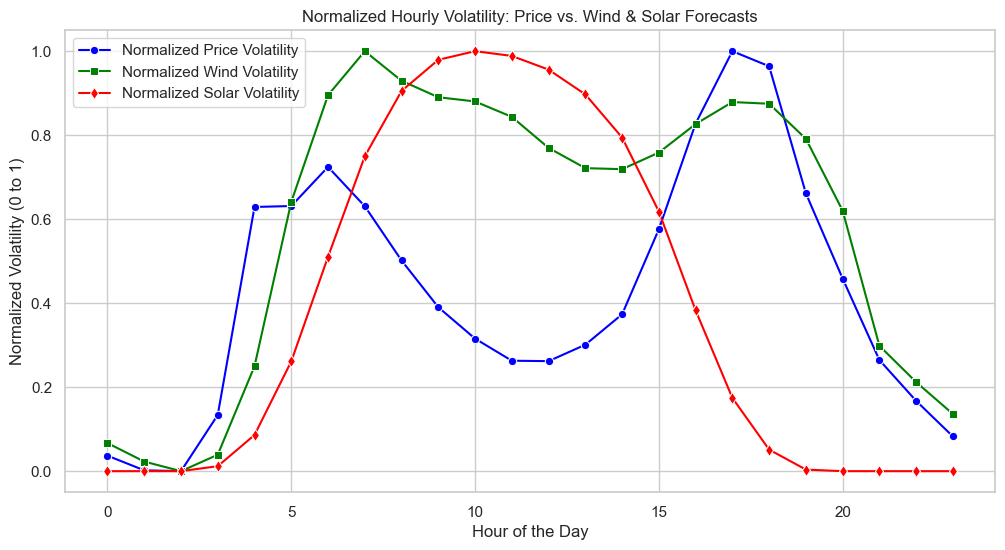

In [199]:
from sklearn.preprocessing import MinMaxScaler
# Normalize using Min-Max Scaling (0 to 1)
scaler = MinMaxScaler()
hourly_stats_scaled = pd.DataFrame(scaler.fit_transform(hourly_stats), columns=hourly_stats.columns, index=hourly_stats.index)

# 🔹 Plot Normalized Volatility
plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")

# Line plots for normalized volatilities
sns.lineplot(data=hourly_stats_scaled, x=hourly_stats_scaled.index, y="Price Volatility", marker="o", label="Normalized Price Volatility", color="blue")
sns.lineplot(data=hourly_stats_scaled, x=hourly_stats_scaled.index, y="Wind Volatility", marker="s", label="Normalized Wind Volatility", color="green")
sns.lineplot(data=hourly_stats_scaled, x=hourly_stats_scaled.index, y="Solar Volatility", marker="d", label="Normalized Solar Volatility", color="red")

# Labels & Titles
plt.xlabel("Hour of the Day")
plt.ylabel("Normalized Volatility (0 to 1)")
plt.title("Normalized Hourly Volatility: Price vs. Wind & Solar Forecasts")
plt.legend()

plt.show()

Observations: With Outliers
- Peak hours (morning/evening) are more stable prob. due to predictable demand.
- Are renewable energy forecasts impacting volatility?
        - High wind fluctuation increases price uncertainty. (they are correlated)
        - Solar: During daylight price-volatility is lower.


In [20]:
# Sort data by delivery time
df = df.sort_values(by="contract-delivery")

# Compute Rolling Volatility (std deviation over past 24 hours)
df["wind_volatility"] = df["wind-forecast"].rolling(window=24, min_periods=1).std()
df["solar_volatility"] = df["solar-forecast"].rolling(window=24, min_periods=1).std()
df["price_volatility"] = df["day-ahead-auction-price"].rolling(window=24, min_periods=1).std()

# Compute Weather Uncertainty (difference between forecast & normal temperature)
df["temperature_deviation"] = np.abs(df["temperature-forecast"] - df["temperature-normal"])

# Drop initial rows with NaNs (from rolling calculations)
df = df.dropna()


In [104]:
# Sort data by delivery time
df_cleaned = df_cleaned.sort_values(by="contract-delivery")

# Compute Rolling Volatility (std deviation over past 24 hours)
df_cleaned["wind_volatility"] = df_cleaned["wind-forecast"].rolling(window=24, min_periods=1).std()
df_cleaned["solar_volatility"] = df_cleaned["solar-forecast"].rolling(window=24, min_periods=1).std()
df_cleaned["price_volatility"] = df_cleaned["day-ahead-auction-price"].rolling(window=24, min_periods=1).std()

# Compute Weather Uncertainty (difference between forecast & normal temperature)
df_cleaned["temperature_deviation"] = np.abs(df_cleaned["temperature-forecast"] - df_cleaned["temperature-normal"])

# Drop initial rows with NaNs (from rolling calculations)
df_cleaned = df_cleaned.dropna()

Text(0.5, 1.0, 'Hourly Wind Volatility')

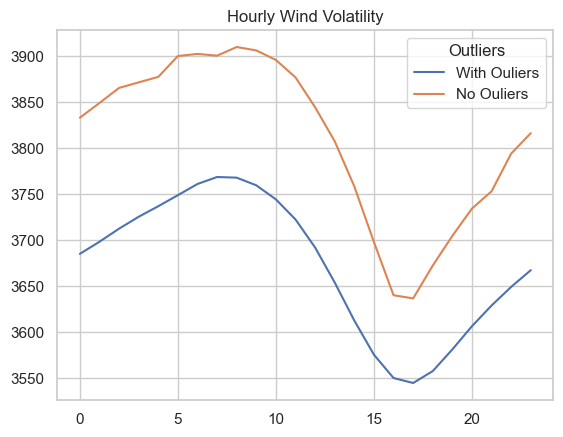

In [105]:
plt.plot(df.groupby('hour')["wind_volatility"].mean(), label = "With Ouliers")
plt.plot(df_cleaned.groupby('hour')["wind_volatility"].mean(), label = "No Ouliers")
# Add a title to a legend 
plt.legend(title = "Outliers") 
plt.title("Hourly Wind Volatility") 

Text(0.5, 1.0, 'Hourly Solar Volatility')

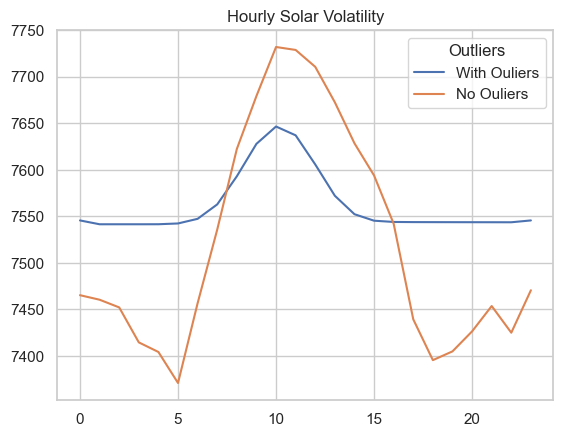

In [106]:
plt.plot(df.groupby('hour')["solar_volatility"].mean(), label = "With Ouliers")
plt.plot(df_cleaned.groupby('hour')["solar_volatility"].mean(), label = "No Ouliers")
# Add a title to a legend 
plt.legend(title = "Outliers") 
plt.title("Hourly Solar Volatility") 

Text(0.5, 1.0, 'Hourly Price Volatility')

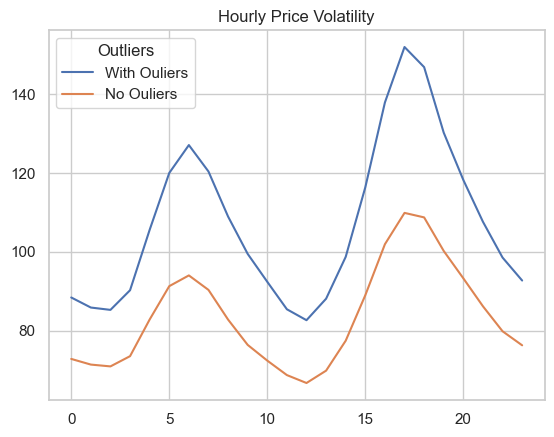

In [107]:
plt.plot(df.groupby('hour')["day-ahead-auction-price"].mean(), label = "With Ouliers" )
plt.plot(df_cleaned.groupby('hour')["day-ahead-auction-price"].mean(), label = "No Ouliers")
# Add a title to a legend 
plt.legend(title = "Outliers") 
plt.title("Hourly Price Volatility") 

In [21]:
# Save new dataset with volatility & uncertainty features
df.to_csv("../data/energy_price_w_volatility_uncertainty.csv", index=False)

In [22]:
df.head()

,contract-delivery,demand-forecast,temperature-normal,temperature-forecast,solar-forecast,day-ahead-auction-price,wind-forecast,day-ahead-auction-time,hour,day_of_week,month,wind_volatility,solar_volatility,price_volatility,temperature_deviation
1,2020-01-01 01:00:00+00:00,42555.50,1.285980,0.3,0.0,36.55,7407.00,2019-12-31 11:00:00+00:00,1,2,1,274.003878,0.0,1.449569,0.985980
2,2020-01-01 02:00:00+00:00,42448.25,1.224420,-0.1,0.0,32.32,7540.50,2019-12-31 11:00:00+00:00,2,2,1,270.622585,0.0,3.202442,1.324420
3,2020-01-01 03:00:00+00:00,42567.75,1.169376,-0.4,0.0,30.85,7802.75,2019-12-31 11:00:00+00:00,3,2,1,326.380809,0.0,3.608407,1.569376
4,2020-01-01 04:00:00+00:00,42209.00,1.101194,-0.7,0.0,30.14,7805.75,2019-12-31 11:00:00+00:00,4,2,1,326.025335,0.0,3.702455,1.801194
5,2020-01-01 05:00:00+00:00,40675.25,1.054676,-0.8,0.0,30.17,7573.00,2019-12-31 11:00:00+00:00,5,2,1,292.562387,0.0,3.610256,1.854676


# Conclusions

## Merge with other Data Sources

Looking at the data, specially data outliers, it is very probable that with just that dataset it is not possible to improve further the models. We could improve predictions by including extra data such as:

    Country
    Holidays
    Special events (dates)
    Fuel prices
    Economic indicators (inflation & interest rates, GDP growth)



## Further Investigation

    Statistical methods + Clustering
    Temporal Fusion Transformers
    DART temporal transformers
    pyTorch.forecasting
    Price Data Transformation: BoxCox Transform: convert to Gaussian pdf